In [35]:
import pandas as pd
import numpy as np
import re
import os
import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from patsy.contrasts import Treatment
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [81]:
"""
Define I/O info
"""
# path to input directory
inDIR = 'C:/Users/sean.kearney/OneDrive - USDA/Documents/Projects/GPS_v_hetgen/data/'
# file name of gridded path intensity data (output from gps_to_gridded_path_intensity.ipynb)
griddata_f = '2017_grazing_time_gridded_all_extracted.csv'

# path to output directory
outDIR = 'C:/Users/sean.kearney/OneDrive - USDA/Documents/Projects/GPS_v_hetgen/models/'

if not os.path.exists(outDIR):
    os.mkdir(outDIR)

In [3]:
"""
Load data and check data types
"""
df_wkly_grid_full = pd.read_csv(os.path.join(inDIR, griddata_f))
display(df_wkly_grid_full.dtypes)

index_id          int64
mod_data         object
week              int64
Pasture          object
Steer_ID         object
UTM_X           float64
UTM_Y           float64
grazing_secs    float64
TPC             float64
dFence          float64
dTank           float64
PC_dmt           object
PC_pct          float64
PC_div          float64
Biomass         float64
CP              float64
DOM             float64
TPC_c            object
dCorner         float64
dtype: object

In [4]:
"""
Add season to dataset based on week
"""

def season_func(wk):
    if wk <= 26:
        return 'early'
    elif wk <= 32:
        return 'mid'
    elif wk >= 33:
        return 'late'

df_wkly_grid_full['season'] = df_wkly_grid_full['week'].apply(lambda x: season_func(x))
df_wkly_grid_full['season'] = pd.Categorical(df_wkly_grid_full['season'], ['early', 'mid', 'late'])

'Number of grazing values > 10,000 = 6'

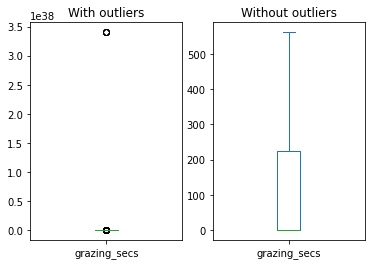

In [5]:
"""
Check grazing intensity values for further cleaning
"""
max_graze_secs = 10000
fig, axs = plt.subplots(nrows=1, ncols=2)
df_wkly_grid_full['grazing_secs'].plot.box(showfliers=True, ax=axs[0], title='With outliers')
df_wkly_grid_full['grazing_secs'].plot.box(showfliers=False, ax=axs[1], title='Without outliers')
display('Number of grazing values > ' + "{:,}".format(max_graze_secs) + ' = ' + "{:,}".format(
    len(df_wkly_grid_full[df_wkly_grid_full['grazing_secs'] > 10000])))

In [6]:
# mask grid cells with seemingly erroneous grazing intensity
df_wkly_grid_full.loc[df_wkly_grid_full['grazing_secs'] > max_graze_secs, 'grazing_secs'] = np.nan

In [7]:
"""
Remove data in corners and near water tanks
"""
df_wkly_grid_full = df_wkly_grid_full[df_wkly_grid_full['dTank'] > 60]
df_wkly_grid_full = df_wkly_grid_full[df_wkly_grid_full['dCorner'] > 60]

In [8]:
"""
Flag and remove any outliers beyond last 60-sec bin with only one pixel
"""

def flag_graze_outliers(x, bins=np.arange(-5, 10000, 60)):
    groups = x.groupby(pd.cut(x, bins, include_lowest=False))
    one_bins = bins[:-1][(groups.count() == 1).values] 
    gt_one_bins = bins[:-1][(groups.count() > 1).values] 
    last_one_bin = np.min([np.max(gt_one_bins) + 60, np.max([np.min(one_bins), np.max(gt_one_bins)])])
    return (x >= last_one_bin).astype('int')
    
df_wkly_grid_full['grazing_secs_outlier'] = df_wkly_grid_full.groupby(['week', 'Pasture', 'Steer_ID'])['grazing_secs'].transform(flag_graze_outliers)
print('Stats of grid cells removed across all steer-weeks:')
display(df_wkly_grid_full.groupby(['week', 'Pasture', 'Steer_ID'])['grazing_secs_outlier'].sum().describe())

Stats of grid cells removed across all steer-weeks:


count    198.000000
mean       6.171717
std        2.908208
min        2.000000
25%        4.000000
50%        6.000000
75%        8.000000
max       19.000000
Name: grazing_secs_outlier, dtype: float64

In [9]:
# remove grazing outliers
df_wkly_grid_full = df_wkly_grid_full[df_wkly_grid_full['grazing_secs_outlier'] == 0]

In [10]:
"""
Calculate weekly grazing minutes per grid cell to account for missing data
"""
# get the sum total of grazing seconds for each steer-week
df_wkly_grid_full['grazing_wkly_sum'] = df_wkly_grid_full.groupby(['Pasture', 'Steer_ID', 'week'])['grazing_secs'].transform('sum')
# get the proportion of the weekly total for each grid cell
df_wkly_grid_full['grazing_wkly_prop'] = df_wkly_grid_full['grazing_secs'] / df_wkly_grid_full['grazing_wkly_sum']
# calculate grazing minutes based on the proportion of a full week
df_wkly_grid_full['grazing_wkly_mins'] = df_wkly_grid_full['grazing_wkly_prop'] * (60*24*7)

In [17]:
"""
Calculate the average weekly values for each grid cell to account for uneven steer sample sizes
"""
# get weekly averages of continuous variables
df_wkly_grid_avg = df_wkly_grid_full.groupby(
    ['UTM_X', 'UTM_Y', 'Pasture', 'week']).mean().reset_index(drop=False)
# get first value of static variables that do not change by week
df_wkly_grid_avg[['season', 'mod_data', 'PC_dmt', 'TPC_c']] = df_wkly_grid_full.groupby(
    ['UTM_X', 'UTM_Y', 'Pasture', 'week']).first().reset_index(drop=False)[['season', 'mod_data', 'PC_dmt', 'TPC_c']]

In [18]:
"""
Organize dataset into training and testing data
"""
df_wkly_grid_test = df_wkly_grid_avg[df_wkly_grid_avg['mod_data'] == 'test']
df_wkly_grid = df_wkly_grid_avg[df_wkly_grid_avg['mod_data'] == 'train']

In [19]:
"""
Check for very rare plant community classes by pasture
"""
pc_dmt_summary = df_wkly_grid.groupby(['Pasture', 'week'])['PC_dmt'].value_counts().groupby(
    ['Pasture', 'PC_dmt']).max().rename('value').to_frame().reset_index().pivot(index='PC_dmt', columns='Pasture')['value']
pc_dmt_summary['Total'] = pc_dmt_summary.sum(axis=1)
display(pc_dmt_summary)

Pasture,15E,17N,20SE,26E,31E,7NW,Total
PC_dmt,,,,,,,
Bare_veg,4.0,1.0,27.0,4.0,20.0,3.0,59.0
C3,NaN,27.0,475.0,3.0,13.0,1.0,519.0
C3_C4_mix,371.0,535.0,339.0,92.0,734.0,946.0,3017.0
C4,1061.0,373.0,243.0,1265.0,844.0,357.0,4143.0
Saltgrass,NaN,440.0,318.0,NaN,5.0,72.0,835.0
Shrub,NaN,2.0,14.0,NaN,NaN,11.0,27.0
UNK,NaN,10.0,9.0,17.0,11.0,2.0,49.0


In [20]:
"""
Check for very rare topographic position classes by pasture
"""
tpc_dmt_summary = df_wkly_grid.groupby(['Pasture', 'week'])['TPC_c'].value_counts().groupby(
    ['Pasture', 'TPC_c']).max().rename('value').to_frame().reset_index().pivot(index='TPC_c', columns='Pasture')['value']
tpc_dmt_summary['Total'] = tpc_dmt_summary.sum(axis=1)
display(tpc_dmt_summary)

Pasture,15E,17N,20SE,26E,31E,7NW,Total
TPC_c,,,,,,,
Flat Plains,346.0,171.0,658.0,841.0,154.0,951.0,3121.0
Highlands,291.0,289.0,44.0,102.0,483.0,77.0,1286.0
Lowlands,346.0,641.0,450.0,170.0,426.0,183.0,2216.0
Open Slopes,448.0,258.0,273.0,269.0,547.0,181.0,1976.0
Other,5.0,29.0,NaN,1.0,17.0,NaN,52.0


In [21]:
"""
Drop rare classes
"""
df_wkly_grid = df_wkly_grid[~df_wkly_grid['PC_dmt'].isin(['Bare', 'Bare_veg', 'UNK', 'Shrub'])]
df_wkly_grid = df_wkly_grid[~df_wkly_grid['TPC_c'].isin(['Other'])]

# print final class numbers
print(df_wkly_grid['TPC_c'].value_counts())
print('\n')
print(df_wkly_grid['PC_dmt'].value_counts())

Flat Plains    24720
Lowlands       17054
Open Slopes    15582
Highlands      10214
Name: TPC_c, dtype: int64


C4           32937
C3_C4_mix    23889
Saltgrass     6608
C3            4136
Name: PC_dmt, dtype: int64


In [22]:
min_class_n = 10
aicw_func = lambda x: np.exp(-0.5 * (x - x.min())) / np.sum(np.exp(-0.5 * (x - x.min())))
aicd_func = lambda x: x - x.min()

m0 = 'grazing_wkly_mins ~ dFence + dTank'
m1 = m0 + ' + C(TPC_c, Treatment(reference="Flat Plains"))'
m2a = m0 + ' + Biomass'
m2b = m0 + ' + Biomass + I(Biomass**2)'
m2c = m0 + ' + CP'
m2d = m2a + ' + CP' 
m2e = m2a + ' + CP + Biomass:CP'
m2f = m2b + ' + CP'
m2g = m2b + ' + CP + Biomass:CP'
m3a = m0 + ' + C(PC_dmt, Treatment(reference="C3_C4_mix"))'
m3b = m0 + ' + PC_div'
m3c = m0 + ' + C(PC_dmt, Treatment(reference="C3_C4_mix")) + PC_div'
m3d = m0 + ' + C(PC_dmt, Treatment(reference="C3_C4_mix")) * PC_div'

model_dict = {
    'M0': m0,
    'M1': m1,
    'M2a': m2a,
    'M2b': m2b,
    'M2c': m2c,
    'M2d': m2d,
    'M2e': m2e,
    'M2f': m2f,
    'M2g': m2g,
    'M3a': m3a,
    'M3b': m3b,
    'M3c': m3c,
    'M3d': m3d
}

In [23]:
"""
Run the initial candidate models
"""
df_results = pd.DataFrame(columns=['week', 'Pasture', 'model', 'formula', 'AIC'])
idx = 0
for group in tqdm(df_wkly_grid.groupby(['week', 'Pasture'])):
    # drop NANs
    data = group[1].dropna(axis=0, how='any')
    
    # remove any locations related to a class with fewer than N observations
    data = data[~data['PC_dmt'].isin(
        data['PC_dmt'].value_counts().index[data['PC_dmt'].value_counts() < min_class_n])]
    data = data[~data['TPC_c'].isin(
        data['TPC_c'].value_counts().index[data['TPC_c'].value_counts() < min_class_n])]
       
    df_results_tmp = pd.DataFrame(columns=['week', 'Pasture', 'model', 'formula', 'AIC'])
    
    # run initial models for negative binomial
    for i in model_dict:
        form = model_dict[i]
        #print('NB: ' + form)
        try:
            md_tmp = smf.glm(form, data, family=sm.families.NegativeBinomial(),
                             offset=np.log(data['grazing_wkly_sum']/60.0))
            mdf_tmp = md_tmp.fit()
            aic_tmp = round(mdf_tmp.aic, 2)
        except (ValueError, np.linalg.LinAlgError):
            aic_tmp = np.nan
        df_tmp = pd.DataFrame({
            'week': group[0][0],
            'season': season_func(group[0][0]),
            'Pasture': group[0][1],
            'model': i,
            'formula': form,
            'AIC': aic_tmp
        }, index=[idx])
        df_results_tmp = df_results_tmp.append(df_tmp)
        idx += 1
        
    df_results = df_results.append(df_results_tmp)
df_results['season'] = pd.Categorical(df_results['season'], ['early', 'mid', 'late'])

  0%|          | 0/48 [00:00<?, ?it/s]

In [24]:
"""
Analyze the top forage condition models
"""
# calculate AIC weights for the forage condition models
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2'])), 
               'AICw_FC'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2']))].groupby(['week', 'Pasture'])['AIC'].transform(
    aicw_func)
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2'])), 
               'AICd_FC'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2']))].groupby(['week', 'Pasture'])['AIC'].transform(
    aicd_func)
df_results['top_model_FC'] = df_results.groupby(['week', 'Pasture'])['AICw_FC'].transform(
    lambda x: [int(i) for i in x == x.max()])
df_results['candidate_model_FC'] = df_results.groupby(['week', 'Pasture'])['AICd_FC'].transform(
    lambda x: [int(i) for i in x <= 2.0])

# print the results by season
display(df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2']))].groupby(['season', 'model'])[['top_model_FC', 'candidate_model_FC', 'AICw_FC', 'AICd_FC']].aggregate(
    func={'AICd_FC': [np.median, np.std], 'AICw_FC': [np.mean, np.std], 'top_model_FC': np.sum, 'candidate_model_FC': np.sum}, axis=1))
display(df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2']))].groupby(['model'])[['top_model_FC', 'candidate_model_FC', 'AICw_FC', 'AICd_FC']].aggregate(
    func={'AICd_FC': [np.median, np.std], 'AICw_FC': [np.mean, np.std], 'top_model_FC': np.sum, 'candidate_model_FC': np.sum}, axis=1))

AICd_FC                   AICw_FC           top_model_FC  \
               median         std          mean       std          sum   
season model                                                             
early  M2a     46.480   59.347148  2.105054e-02  0.066307            0   
       M2b     28.545   41.595856  4.482712e-02  0.091801            1   
       M2c     55.240   83.766058  2.264990e-02  0.095805            1   
       M2d     19.350   53.099368  3.105445e-02  0.063824            0   
       M2e      6.540   15.016862  1.527321e-01  0.249046            3   
       M2f      3.650   15.116630  2.215112e-01  0.240397            4   
       M2g      0.275    1.081198  5.061748e-01  0.296941            9   
mid    M2a    105.395  110.054974  7.381332e-05  0.000313            0   
       M2b     90.820  106.598850  2.932907e-02  0.123558            1   
       M2c    160.450  114.654101  5.493250e-07  0.000002            0   
       M2d     35.230   36.685161  5.904228e-02  0.134963            1   
       M2e     16.580   29.966809  1.357531e-01  0.215604            2   
       M2f     10.395   34.692182  1.217726e-01  0.168370            2   
       M2g      0.000    1.147310  6.540285e-01  0.360957           12   
late   M2a     48.850   38.307737  4.953916e-03  0.011591            0   
       M2b     28.425   32.462956  8.392830e-02  0.201161            1   
       M2c     34.785  163.188775  6.374583e-04  0.001683            0   
       M2d     22.035   29.178889  6.553204e-02  0.153503            1   
       M2e     17.635   17.977953  1.075712e-01  0.192545            1   
       M2f      3.970   13.607834  1.704526e-01  0.196187            2   
       M2g      0.000    1.393833  5.669245e-01  0.357838            7   

             candidate_model_FC  
                            sum  
season model                     
early  M2a                    1  
       M2b                    2  
       M2c                    1  
       M2d                    3  
       M2e                    5  
       M2f                    8  
       M2g                   16  
mid    M2a                    0  
       M2b                    1  
       M2c                    0  
       M2d                    2  
       M2e                    5  
       M2f                    6  
       M2g                   16  
late   M2a                    0  
       M2b                    2  
       M2c                    0  
       M2d                    2  
       M2e                    3  
       M2f                    5  
       M2g                   10

AICd_FC               AICw_FC           top_model_FC candidate_model_FC
       median         std      mean       std          sum                sum
model                                                                        
M2a    71.340   89.428555  0.009160  0.041377            0                  1
M2b    38.480   83.472705  0.048791  0.136041            3                  5
M2c    87.710  120.894697  0.008653  0.058657            1                  1
M2d    20.395   41.549821  0.050169  0.117503            2                  7
M2e    13.790   22.678330  0.135075  0.219630            6                 13
M2f     4.550   25.114508  0.171345  0.205110            8                 19
M2g     0.000    1.166435  0.576807  0.336463           28                 42

In [25]:
"""
Analyze the top plant community models
"""
# calculate AIC weights and delta for the plant community models
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M3'])), 
               'AICw_PC'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M3']))].groupby(['week', 'Pasture'])['AIC'].transform(
    aicw_func)
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M3'])), 
               'AICd_PC'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M3']))].groupby(['week', 'Pasture'])['AIC'].transform(
    aicd_func)
df_results['top_model_PC'] = df_results.groupby(['week', 'Pasture'])['AICw_PC'].transform(
    lambda x: [int(i) for i in x == x.max()])
df_results['candidate_model_PC'] = df_results.groupby(['week', 'Pasture'])['AICd_PC'].transform(
    lambda x: [int(i) for i in x <= 2.0])

# print the results by season
display(df_results.loc[df_results['model'].str.contains(
    '|'.join(['M3']))].groupby(['season', 'model'])[['top_model_PC', 'candidate_model_PC', 'AICw_PC', 'AICd_PC']].aggregate(
    func={'AICd_PC': [np.median, np.std], 'AICw_PC': [np.mean, np.std], 'top_model_PC': np.sum, 'candidate_model_PC': np.sum}, axis=1))
display(df_results.loc[df_results['model'].str.contains(
    '|'.join(['M3']))].groupby(['model'])[['top_model_PC', 'candidate_model_PC', 'AICw_PC', 'AICd_PC']].aggregate(
    func={'AICd_PC': [np.median, np.std], 'AICw_PC': [np.mean, np.std], 'top_model_PC': np.sum, 'candidate_model_PC': np.sum}, axis=1))

AICd_PC               AICw_PC           top_model_PC  \
              median         std      mean       std          sum   
season model                                                        
early  M3a    70.450   73.256237  0.007976  0.024471            0   
       M3b    80.540   56.733009  0.064009  0.177415            2   
       M3c    26.315   29.946018  0.095890  0.190138            1   
       M3d     0.000    1.032040  0.832125  0.309496           15   
mid    M3a    29.090   35.045365  0.101575  0.193861            3   
       M3b    39.040   69.649046  0.021825  0.048071            0   
       M3c    11.045   20.113008  0.130456  0.212502            2   
       M3d     0.000    1.070734  0.746144  0.347869           13   
late   M3a    20.660  105.908803  0.119436  0.225795            2   
       M3b    45.940  110.560203  0.025191  0.085497            0   
       M3c    13.945   26.272479  0.114011  0.155722            1   
       M3d     0.000    1.013235  0.741362  0.365349            9   

             candidate_model_PC  
                            sum  
season model                     
early  M3a                    0  
       M3b                    2  
       M3c                    4  
       M3d                   16  
mid    M3a                    3  
       M3b                    0  
       M3c                    5  
       M3d                   15  
late   M3a                    3  
       M3b                    1  
       M3c                    4  
       M3d                   10

AICd_PC              AICw_PC           top_model_PC candidate_model_PC
       median        std      mean       std          sum                sum
model                                                                       
M3a    35.625  75.510973  0.070941  0.167990            5                  6
M3b    47.535  76.568497  0.038485  0.119719            2                  3
M3c    14.870  26.114795  0.113383  0.187921            4                 13
M3d     0.000   1.022454  0.777191  0.333931           37                 41

In [26]:
"""
Define the top vegetation models
"""
m2_top = m2g
m3_top = m3d

m4a = m2_top + re.sub(re.escape(m0), '', m3_top)
m4b = m4a + ' + C(PC_dmt, Treatment(reference="C3_C4_mix")):Biomass'
m4c = m4a + ' + C(PC_dmt, Treatment(reference="C3_C4_mix")):CP'
m4d = m4a + ' + PC_div:Biomass'
m4e = m4a + ' + PC_div:CP'
m4f = m4b + ' + C(PC_dmt, Treatment(reference="C3_C4_mix")):CP'
m4g = m4d + ' + PC_div:CP'
m4h = m4b + ' + PC_div:Biomass + C(PC_dmt, Treatment(reference="C3_C4_mix")):CP + PC_div:CP'

model_dict_veg = {
    'M4a': m4a,
    'M4b': m4b,
    'M4c': m4c,
    'M4d': m4d,
    'M4e': m4e,
    'M4f': m4f,
    'M4g': m4g,
    'M4h': m4h
}

In [27]:
"""
Run additional vegetation models
"""
for group in tqdm(df_wkly_grid.groupby(['week', 'Pasture'])):
    # drop NANs
    data = group[1].dropna(axis=0, how='any')

    # remove any locations related to a class with fewer than N observations
    data = data[~data['PC_dmt'].isin(
        data['PC_dmt'].value_counts().index[data['PC_dmt'].value_counts() < min_class_n])]
    data = data[~data['TPC_c'].isin(
        data['TPC_c'].value_counts().index[data['TPC_c'].value_counts() < min_class_n])]
       
    df_results_tmp = pd.DataFrame(columns=['week', 'Pasture', 'model', 'formula', 'AIC'])
    
    # run forage condition models for negative binomial
    for i in model_dict_veg:
        form = model_dict_veg[i]
        #print('NB: ' + form)
        try:
            md_tmp = smf.glm(form, data, family=sm.families.NegativeBinomial(),
                             offset=np.log(data['grazing_wkly_sum']/60.0))
            mdf_tmp = md_tmp.fit()
            aic_tmp = round(mdf_tmp.aic, 2)
        except (ValueError, np.linalg.LinAlgError):
            aic_tmp = np.nan
        df_tmp = pd.DataFrame({
            'week': group[0][0],
            'season': season_func(group[0][0]),
            'Pasture': group[0][1],
            'model': i,
            'formula': form,
            'AIC': aic_tmp
        }, index=[idx])
        df_results_tmp = df_results_tmp.append(df_tmp)
        idx += 1
        
    df_results = df_results.append(df_results_tmp)
df_results['season'] = pd.Categorical(df_results['season'], ['early', 'mid', 'late'])

  0%|          | 0/48 [00:00<?, ?it/s]

In [28]:
"""
Analyze the top vegetation models
"""
# calculate AIC weights for the forage condition models
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M4'])), 
               'AICw_VEG'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M4']))].groupby(['week', 'Pasture'])['AIC'].transform(
    aicw_func)
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M4'])), 
               'AICd_VEG'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M4']))].groupby(['week', 'Pasture'])['AIC'].transform(
    aicd_func)
df_results['top_model_VEG'] = df_results.groupby(['week', 'Pasture'])['AICw_VEG'].transform(
    lambda x: [int(i) for i in x == x.max()])
df_results['candidate_model_VEG'] = df_results.groupby(['week', 'Pasture'])['AICd_VEG'].transform(
    lambda x: [int(i) for i in x <= 2.0])

# print the results by season
display(df_results.loc[df_results['model'].str.contains(
    '|'.join(['M4']))].groupby(['season', 'model'])[['top_model_VEG', 'candidate_model_VEG', 'AICw_VEG', 'AICd_VEG']].aggregate(
    func={'AICd_VEG': [np.median, np.std], 'AICw_VEG': [np.mean, np.std], 'top_model_VEG': np.sum, 'candidate_model_VEG': np.sum}, axis=1))
display(df_results.loc[df_results['model'].str.contains(
    '|'.join(['M4']))].groupby(['model'])[['top_model_VEG', 'candidate_model_VEG', 'AICw_VEG', 'AICd_VEG']].aggregate(
    func={'AICd_VEG': [np.median, np.std], 'AICw_VEG': [np.mean, np.std], 'top_model_VEG': np.sum, 'candidate_model_VEG': np.sum}, axis=1))

AICd_VEG             AICw_VEG           top_model_VEG  \
               median        std      mean       std           sum   
season model                                                         
early  M4a     22.600  17.168621  0.016853  0.040185             0   
       M4b     13.485  12.872126  0.024909  0.057093             0   
       M4c     12.580  18.288108  0.058582  0.190484             1   
       M4d     15.120  18.452059  0.089814  0.173196             4   
       M4e     21.720  16.786882  0.018256  0.046722             0   
       M4f      8.655  10.713622  0.066401  0.150738             1   
       M4g      8.370  18.283824  0.090077  0.165411             1   
       M4h      0.000   1.869959  0.635108  0.399908            11   
mid    M4a     18.125  20.806234  0.016779  0.028504             0   
       M4b     15.460  17.368327  0.007640  0.015937             0   
       M4c     16.635  14.334588  0.088771  0.195478             2   
       M4d      7.480  19.438685  0.075255  0.160175             1   
       M4e     15.540  15.335320  0.089476  0.159009             3   
       M4f     12.450  11.478901  0.065472  0.167428             1   
       M4g      4.265  12.332934  0.159646  0.217387             2   
       M4h      0.450   2.272409  0.496962  0.435881             9   
late   M4a     20.710  23.491420  0.018119  0.056573             0   
       M4b     17.160  15.783494  0.077497  0.164522             2   
       M4c     11.960  17.147658  0.023231  0.058085             0   
       M4d     20.730  21.308883  0.043317  0.078529             1   
       M4e     12.720  24.842197  0.033959  0.073357             0   
       M4f      1.800  15.527875  0.265259  0.309491             4   
       M4g     10.685  22.117396  0.076308  0.176535             1   
       M4h      0.805   1.416035  0.462310  0.354889             4   

             candidate_model_VEG  
                             sum  
season model                      
early  M4a                     1  
       M4b                     1  
       M4c                     1  
       M4d                     4  
       M4e                     0  
       M4f                     2  
       M4g                     5  
       M4h                    14  
mid    M4a                     0  
       M4b                     0  
       M4c                     4  
       M4d                     2  
       M4e                     4  
       M4f                     2  
       M4g                     7  
       M4h                    10  
late   M4a                     1  
       M4b                     2  
       M4c                     1  
       M4d                     1  
       M4e                     2  
       M4f                     7  
       M4g                     2  
       M4h                     8

AICd_VEG             AICw_VEG           top_model_VEG  \
        median        std      mean       std           sum   
model                                                         
M4a     20.070  19.869016  0.017142  0.040340             0   
M4b     14.940  15.172204  0.031580  0.091546             2   
M4c     13.345  16.276602  0.061065  0.168513             3   
M4d     12.635  19.272228  0.072730  0.148014             6   
M4e     17.805  18.476669  0.048889  0.110641             3   
M4f      9.375  12.110922  0.115767  0.219963             6   
M4g      8.095  17.443158  0.112723  0.188842             4   
M4h      0.025   1.940779  0.540104  0.402191            24   

      candidate_model_VEG  
                      sum  
model                      
M4a                     2  
M4b                     3  
M4c                     6  
M4d                     7  
M4e                     6  
M4f                    11  
M4g                    14  
M4h                    32

In [29]:
"""
Define full models with TPC
"""
m4_top = m4h


m2_tpc = m2_top + re.sub(re.escape(m0), '', m1)
m3_tpc = m3_top + re.sub(re.escape(m0), '', m1)
m5 = m4_top + re.sub(re.escape(m0), '', m1)

model_dict_topo = {
    'M2_tpc': m2_tpc,
    'M3_tpc': m3_tpc,
    'M5': m5
}

In [30]:
"""
Run full models
"""
for group in tqdm(df_wkly_grid.groupby(['week', 'Pasture'])):
    # drop NANs
    data = group[1].dropna(axis=0, how='any')
    
    # remove any locations related to a class with fewer than N observations
    data = data[~data['PC_dmt'].isin(
        data['PC_dmt'].value_counts().index[data['PC_dmt'].value_counts() < min_class_n])]
    data = data[~data['TPC_c'].isin(
        data['TPC_c'].value_counts().index[data['TPC_c'].value_counts() < min_class_n])]
       
    df_results_tmp = pd.DataFrame(columns=['week', 'Pasture', 'model', 'formula', 'AIC'])
    
    # run TPC models for negative binomial
    for i in model_dict_topo:
        form = model_dict_topo[i]
        #print('NB: ' + form)
        try:
            md_tmp = smf.glm(form, data, family=sm.families.NegativeBinomial(),
                             offset=np.log(data['grazing_wkly_sum']/60.0))
            mdf_tmp = md_tmp.fit()
            aic_tmp = round(mdf_tmp.aic, 2)
        except (ValueError, np.linalg.LinAlgError):
            aic_tmp = np.nan
        df_tmp = pd.DataFrame({
            'week': group[0][0],
            'season': season_func(group[0][0]),
            'Pasture': group[0][1],
            'model': i,
            'formula': form,
            'AIC': aic_tmp
        }, index=[idx])
        df_results_tmp = df_results_tmp.append(df_tmp)
        idx += 1
        
    df_results = df_results.append(df_results_tmp)
df_results['season'] = pd.Categorical(df_results['season'], ['early', 'mid', 'late'])

  0%|          | 0/48 [00:00<?, ?it/s]

In [31]:
"""
Calculate results for final models
"""
# calculate AIC weights for the topography interaction models
df_results.loc[(df_results['formula'] == m0) |
                       (df_results['formula'] == m1) |
                       (df_results['formula'] == m2_top) |
                       (df_results['formula'] == m3_top) | 
                       (df_results['formula'] == m4_top) |
                       (df_results['formula'] == m5), 
               'AICw_ALL'] = df_results.loc[(df_results['formula'] == m0) |
                       (df_results['formula'] == m1) |
                       (df_results['formula'] == m2_top) |
                       (df_results['formula'] == m3_top) | 
                       (df_results['formula'] == m4_top) |
                       (df_results['formula'] == m5)].groupby(['week', 'Pasture'])['AIC'].transform(
    aicw_func)
df_results.loc[(df_results['formula'] == m0) |
                       (df_results['formula'] == m1) |
                       (df_results['formula'] == m2_top) |
                       (df_results['formula'] == m3_top) | 
                       (df_results['formula'] == m4_top) |
                       (df_results['formula'] == m5), 
               'AICd_ALL'] = df_results.loc[(df_results['formula'] == m0) |
                       (df_results['formula'] == m1) |
                       (df_results['formula'] == m2_top) |
                       (df_results['formula'] == m3_top) | 
                       (df_results['formula'] == m4_top) |
                       (df_results['formula'] == m5)].groupby(['week', 'Pasture'])['AIC'].transform(
    aicd_func)
df_results['top_model_ALL'] = df_results.groupby(['week', 'Pasture'])['AICw_ALL'].transform(
    lambda x: [int(i) for i in x == x.max()])
df_results['candidate_model_ALL'] = df_results.groupby(['week', 'Pasture'])['AICd_ALL'].transform(
    lambda x: [int(i) for i in x <= 2.0])

display(df_results.loc[(df_results['formula'] == m0) |
                       (df_results['formula'] == m1) |
                       (df_results['formula'] == m2_top) |
                       (df_results['formula'] == m3_top) | 
                       (df_results['formula'] == m4_top) |
                       (df_results['formula'] == m5)].groupby(['model'])[['top_model_ALL', 'candidate_model_ALL', 
                                                                              'AICw_ALL', 'AICd_ALL']].aggregate(
    func={'AICd_ALL': [np.median, np.std], 'AICw_ALL': [np.mean, np.std], 
          'top_model_ALL': np.sum, 'candidate_model_ALL': np.sum}, axis=1))

AICd_ALL                  AICw_ALL               top_model_ALL  \
        median         std          mean           std           sum   
model                                                                  
M0     328.925  148.470438  1.813907e-19  1.248057e-18             0   
M1     202.585  131.378234  1.296255e-08  8.980716e-08             0   
M2g    159.165   94.631073  2.022025e-04  1.400865e-03             0   
M3d    198.950  110.870274  1.505214e-09  7.313006e-09             0   
M4h     31.410   50.787846  5.910060e-02  1.943128e-01             3   
M5       0.000    0.689626  9.406972e-01  1.942554e-01            45   

      candidate_model_ALL  
                      sum  
model                      
M0                      0  
M1                      0  
M2g                     0  
M3d                     0  
M4h                     3  
M5                     46

In [33]:
"""
Extract coefficients for each pasture-week for top models and other models of interest
"""
top_mod_dict = {
    'M0': m0,
    'M1': m1,
    'M2_bm': m2b,
    'M2_top': m2_top,
    'M3_pc': m3a,
    'M3_top': m3_top,
    'M4_top': m4_top,
    'M5_top': m5
}
idx = 0
for mod in tqdm(top_mod_dict):
    form = top_mod_dict[mod]
    for seas in df_wkly_grid['season'].unique():
        for group in df_wkly_grid[df_wkly_grid['season'] == seas].groupby(['week', 'Pasture']):
            # remove any locations related to a class with fewer than N observations
            data = group[1]
            data['Model'] = mod
            data['Formula'] = form
            data = data[~data['PC_dmt'].isin(
                data['PC_dmt'].value_counts().index[data['PC_dmt'].value_counts() < min_class_n])]
            data = data[~data['TPC_c'].isin(
                data['TPC_c'].value_counts().index[data['TPC_c'].value_counts() < min_class_n])]
            md_tmp = smf.glm(form, data=data,
                         family=sm.families.NegativeBinomial(),
                             offset=np.log(data['grazing_wkly_sum']))
            try:
                mdf_tmp = md_tmp.fit()
                if idx == 0:
                    coefs = pd.DataFrame(dict(coef=mdf_tmp.params, 
                                              week=group[0][0],
                                              Pasture=group[0][1],
                                              Season=seas,
                                              Model=mod,
                                              Formula=form))
                    idx += 1
                    df_mods_tmp = data
                else:
                    coefs = coefs.append(pd.DataFrame(dict(coef=mdf_tmp.params, 
                                                           week=group[0][0], 
                                                           Pasture=group[0][1], 
                                                           Season=seas,
                                                           Model=mod,
                                                           Formula=form)))
                    idx += 1
                    df_mods_tmp = df_mods_tmp.append(data)            
                #print(group[0])
            except ValueError:
                pass
coefs = coefs.rename_axis('Param').reset_index()
coefs['Season'] = pd.Categorical(coefs['Season'], ['early', 'mid', 'late'])

  0%|          | 0/8 [00:00<?, ?it/s]

In [36]:
"""
Build top models for each season across all pastures
"""
seas_mod_dict = {}
for seas in coefs['Season'].unique():
    print(seas)
    seas_mod_dict[seas] = {}
    for mod in tqdm(top_mod_dict):
        form = top_mod_dict[mod]
        df_tmp = df_mods_tmp[(df_mods_tmp['season'] == seas) & (df_mods_tmp['Model'] == mod)]
        coefs_tmp = coefs[(coefs['Season'] == seas) & (coefs['Model'] == mod)][['Param', 'coef']]
        md_tmp = smf.glm(form, data=df_tmp,
                         family=sm.families.NegativeBinomial(),
                             offset=np.log(df_tmp['grazing_wkly_sum']))
        try:
            mdf_tmp = md_tmp.fit()
        except ValueError:
            mdf_tmp = md_tmp.fit(method="lbfgs")
        for idx, i in enumerate(mdf_tmp.params.index):
            mdf_tmp.params[idx] = coefs_tmp.groupby('Param').mean().loc[i]['coef']
        coefs_ci = coefs_tmp.groupby('Param')['coef'].apply(lambda x: sms.DescrStatsW(x).tconfint_mean()).reindex(mdf_tmp.conf_int().index)
        mdf_tmp.conf_int()[0] = coefs_ci.apply(lambda x: x[0])
        mdf_tmp.conf_int()[1] = coefs_ci.apply(lambda x: x[1])
        seas_mod_dict[seas][mod] = mdf_tmp        

early


  0%|          | 0/8 [00:00<?, ?it/s]

mid


  0%|          | 0/8 [00:00<?, ?it/s]

late


  0%|          | 0/8 [00:00<?, ?it/s]

In [37]:
"""
Build top models for each pasture across all seasons
"""
past_mod_dict = {}
for past in coefs['Pasture'].unique():
    print(past)
    past_mod_dict[past] = {}
    for mod in tqdm(top_mod_dict):
        form = top_mod_dict[mod]
        df_tmp = df_mods_tmp[(df_mods_tmp['Pasture'] == past) & (df_mods_tmp['Model'] == mod)]
        coefs_tmp = coefs[(coefs['Pasture'] == past) & (coefs['Model'] == mod)][['Param', 'coef']]
        md_tmp = smf.glm(form, data=df_tmp,
                         family=sm.families.NegativeBinomial(),
                             offset=np.log(df_tmp['grazing_wkly_sum']))
        try:
            mdf_tmp = md_tmp.fit()
        except ValueError:
            mdf_tmp = md_tmp.fit(method="lbfgs")
        #mdf_tmp.params = coefs_tmp.groupby('Param').mean().reindex(mdf_tmp.params.index)
        for idx, i in enumerate(mdf_tmp.params.index):
            mdf_tmp.params[idx] = coefs_tmp.groupby('Param').mean().loc[i]['coef']
        coefs_ci = coefs_tmp.groupby('Param')['coef'].apply(lambda x: sms.DescrStatsW(x).tconfint_mean()).reindex(mdf_tmp.conf_int().index)
        mdf_tmp.conf_int()[0] = coefs_ci.apply(lambda x: x[0])
        mdf_tmp.conf_int()[1] = coefs_ci.apply(lambda x: x[1])
        past_mod_dict[past][mod] = mdf_tmp        

15E


  0%|          | 0/8 [00:00<?, ?it/s]

17N


  0%|          | 0/8 [00:00<?, ?it/s]

20SE


  0%|          | 0/8 [00:00<?, ?it/s]

26E


  0%|          | 0/8 [00:00<?, ?it/s]

31E


  0%|          | 0/8 [00:00<?, ?it/s]

7NW


  0%|          | 0/8 [00:00<?, ?it/s]

In [38]:
"""
Build overall top models
"""
fnl_mod_dict = {}
for mod in tqdm(top_mod_dict):
    form = top_mod_dict[mod]
    df_tmp = df_mods_tmp[df_mods_tmp['Model'] == mod]
    coefs_tmp = coefs[coefs['Model'] == mod][['Param', 'coef']]
    md_tmp = smf.glm(form, data=df_tmp,
                     family=sm.families.NegativeBinomial(),
                             offset=np.log(df_tmp['grazing_wkly_sum']))
    try:
        mdf_tmp = md_tmp.fit()
    except ValueError:
        mdf_tmp = md_tmp.fit(method="lbfgs")
    #mdf_tmp.params = coefs_tmp.groupby('Param').mean().reindex(mdf_tmp.params.index)
    for idx, i in enumerate(mdf_tmp.params.index):
        mdf_tmp.params[idx] = coefs_tmp.groupby('Param').mean().loc[i]['coef']
    coefs_ci = coefs_tmp.groupby('Param')['coef'].apply(lambda x: sms.DescrStatsW(x).tconfint_mean()).reindex(mdf_tmp.conf_int().index)
    mdf_tmp.conf_int()[0] = coefs_ci.apply(lambda x: x[0])
    mdf_tmp.conf_int()[1] = coefs_ci.apply(lambda x: x[1])
    fnl_mod_dict[mod] = mdf_tmp        

  0%|          | 0/8 [00:00<?, ?it/s]

In [89]:
import pickle
for m in fnl_mod_dict:
    if not os.path.exists(os.path.join(outDIR, 'full/')):
        os.mkdir(os.path.join(outDIR, 'full/'))
    fnl_mod_dict[m].save(os.path.join(outDIR, 'full/', 'grazing_intensity_mod_2017_' + m + '.pkl'))
for seas in seas_mod_dict:
    if not os.path.exists(os.path.join(outDIR, 'seas/')):
        os.mkdir(os.path.join(outDIR, 'seas/'))
    for m in seas_mod_dict[seas]:
        seas_mod_dict[seas][m].save(os.path.join(outDIR, 'seas/', 'grazing_intensity_mod_2017_' + seas + '_' + m + '.pkl'))
for past in past_mod_dict:
    if not os.path.exists(os.path.join(outDIR, 'past/')):
        os.mkdir(os.path.join(outDIR, 'past/'))
    for m in past_mod_dict[past]:
        past_mod_dict[past][m].save(os.path.join(outDIR, 'past/', 'grazing_intensity_mod_2017_' + past + '_' + m + '.pkl'))


In [74]:
df_wkly_grid_full = df_wkly_grid_full[~df_wkly_grid_full['PC_dmt'].isin(['Bare', 'Bare_veg', 'UNK', 'Shrub'])]
df_wkly_grid_full = df_wkly_grid_full[~df_wkly_grid_full['TPC_c'].isin(['Other'])]

df_wkly_grid_full['pred_M5_overall'] = fnl_mod_dict['M5_top'].predict(df_wkly_grid_full)
for seas, df_sub in df_wkly_grid_full.groupby('season'):
    df_wkly_grid_full.loc[df_wkly_grid_full['season'] == seas, 'pred_M5_seas'] = seas_mod_dict[seas]['M5_top'].predict(df_sub)
for past, df_sub in df_wkly_grid_full.groupby('Pasture'):
    df_wkly_grid_full.loc[df_wkly_grid_full['Pasture'] == past, 'pred_M5_past'] = seas_mod_dict[seas]['M5_top'].predict(df_sub)
df_wkly_grid_full.loc[(df_wkly_grid_full['pred_M5_overall'] > 1.0), 'pred_M5_overall'] = 1.0
df_wkly_grid_full.loc[(df_wkly_grid_full['pred_M5_seas'] > 1.0), 'pred_M5_seas'] = 1.0
df_wkly_grid_full.loc[(df_wkly_grid_full['pred_M5_past'] > 1.0), 'pred_M5_past'] = 1.0

<AxesSubplot:xlabel='pred_M5_past_grp', ylabel='grazing_wkly_mins'>

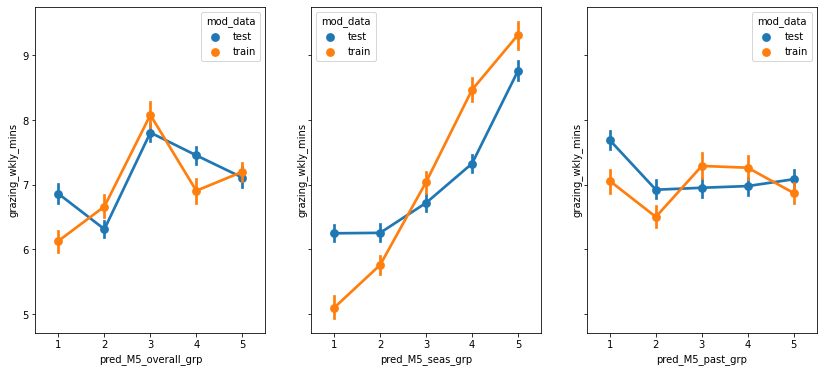

In [75]:

df_wkly_grid_full['pred_M5_overall_grp'] = pd.cut(df_wkly_grid_full['pred_M5_overall'], 
                                          bins=np.concatenate([np.array([0.0]), np.nanquantile(df_wkly_grid_full['pred_M5_overall'],
                                                          [0.2, 0.4, 0.6, 0.8, 1.0])]), 
                                          labels=['1', '2', '3', '4', '5'],
                                          include_lowest=True)
df_wkly_grid_full['pred_M5_seas_grp'] = pd.cut(df_wkly_grid_full['pred_M5_seas'], 
                                          bins=np.concatenate([np.array([0.0]), np.nanquantile(df_wkly_grid_full['pred_M5_seas'],
                                                          [0.2, 0.4, 0.6, 0.8, 1.0])]), 
                                          labels=['1', '2', '3', '4', '5'],
                                          include_lowest=True)
df_wkly_grid_full['pred_M5_past_grp'] = pd.cut(df_wkly_grid_full['pred_M5_past'], 
                                          bins=np.concatenate([np.array([0.0]), np.nanquantile(df_wkly_grid_full['pred_M5_past'],
                                                          [0.2, 0.4, 0.6, 0.8, 1.0])]), 
                                          labels=['1', '2', '3', '4', '5'],
                                          include_lowest=True)
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(14, 6))
sns.pointplot(x='pred_M5_overall_grp', y='grazing_wkly_mins', data=df_wkly_grid_full, ax=axs[0], hue='mod_data')
sns.pointplot(x='pred_M5_seas_grp', y='grazing_wkly_mins', data=df_wkly_grid_full, ax=axs[1], hue='mod_data')
sns.pointplot(x='pred_M5_past_grp', y='grazing_wkly_mins', data=df_wkly_grid_full, ax=axs[2], hue='mod_data')

In [60]:
"""
Analyze best results for top models with TPC
"""
# calculate AIC weights for the top forage conditions and TPC model
df_results.loc[(df_results['formula'] == m2_top) | 
               (df_results['formula'] == m2_tpc), 
               'AICw_TPC2'] = df_results.loc[(df_results['formula'] == m2_top) | 
                                             (df_results['formula'] == m2_tpc)].groupby(['week', 'Pasture'])['AIC'].transform(
    aicw_func)
df_results.loc[(df_results['formula'] == m2_top) | 
               (df_results['formula'] == m2_tpc), 
               'AICd_TPC2'] = df_results.loc[(df_results['formula'] == m2_top) | 
                                             (df_results['formula'] == m2_tpc)].groupby(['week', 'Pasture'])['AIC'].transform(
    aicd_func)
df_results['top_model_TPC2'] = df_results.groupby(['week', 'Pasture'])['AICw_TPC2'].transform(
    lambda x: [int(i) for i in x == x.max()])
df_results['candidate_model_TPC2'] = df_results.groupby(['week', 'Pasture'])['AICd_TPC2'].transform(
    lambda x: [int(i) for i in x <= 2.0])

# calculate AIC weights for the top plant community and TPC model
df_results.loc[(df_results['formula'] == m3_top) | 
               (df_results['formula'] == m3_tpc), 
               'AICw_TPC3'] = df_results.loc[(df_results['formula'] == m3_top) | 
                                             (df_results['formula'] == m3_tpc)].groupby(['week', 'Pasture'])['AIC'].transform(
    aicw_func)
df_results.loc[(df_results['formula'] == m3_top) | 
               (df_results['formula'] == m3_tpc), 
               'AICd_TPC3'] = df_results.loc[(df_results['formula'] == m3_top) | 
                                             (df_results['formula'] == m3_tpc)].groupby(['week', 'Pasture'])['AIC'].transform(
    aicd_func)
df_results['top_model_TPC3'] = df_results.groupby(['week', 'Pasture'])['AICw_TPC3'].transform(
    lambda x: [int(i) for i in x == x.max()])
df_results['candidate_model_TPC3'] = df_results.groupby(['week', 'Pasture'])['AICd_TPC3'].transform(
    lambda x: [int(i) for i in x <= 2.0])


df_results.loc[(df_results['formula'] == m4_top) | 
               (df_results['formula'] == m5), 
               'AICw_TPC4'] = df_results.loc[(df_results['formula'] == m4_top) | 
                                             (df_results['formula'] == m5)].groupby(['week', 'Pasture'])['AIC'].transform(
    aicw_func)
df_results.loc[(df_results['formula'] == m4_top) | 
               (df_results['formula'] == m5), 
               'AICd_TPC4'] = df_results.loc[(df_results['formula'] == m4_top) | 
                                             (df_results['formula'] == m5)].groupby(['week', 'Pasture'])['AIC'].transform(
    aicd_func)
df_results['top_model_TPC4'] = df_results.groupby(['week', 'Pasture'])['AICw_TPC4'].transform(
    lambda x: [int(i) for i in x == x.max()])
df_results['candidate_model_TPC4'] = df_results.groupby(['week', 'Pasture'])['AICd_TPC4'].transform(
    lambda x: [int(i) for i in x <= 2.0])

In [61]:
# print the results by season compared to forage quality
display(df_results.loc[(df_results['formula'] == m2_top) | 
               (df_results['formula'] == m2_tpc)].groupby(['season', 'model'])[['top_model_TPC2', 'candidate_model_TPC2',
                                                                                'AICw_TPC2', 'AICd_TPC2']].aggregate(
    func={'top_model_TPC2': np.sum, 'candidate_model_TPC2': np.sum, 'AICw_TPC2': np.mean, 'AICd_TPC2': np.mean}, axis=1))
display(df_results.loc[(df_results['formula'] == m2_top) | 
               (df_results['formula'] == m2_tpc)].groupby(['model'])[['top_model_TPC2', 'candidate_model_TPC2', 
                                                                      'AICw_TPC2', 'AICd_TPC2']].aggregate(
    func={'AICd_TPC2': [np.median, np.std], 'AICw_TPC2': [np.mean, np.std], 
          'top_model_TPC2': np.sum, 'candidate_model_TPC2': np.sum}, axis=1))

top_model_TPC2  candidate_model_TPC2  AICw_TPC2  AICd_TPC2
season model                                                             
early  M2_tpc              18                    18   0.999962   0.000000
       M2g                  0                     0   0.000038  74.561667
mid    M2_tpc              17                    17   0.941111   0.115000
       M2g                  1                     2   0.058889  64.822222
late   M2_tpc              11                    11   0.928963   0.174167
       M2g                  1                     1   0.071037  46.172500

AICd_TPC2            AICw_TPC2           top_model_TPC2  \
          median        std      mean       std            sum   
model                                                            
M2_tpc     0.000   0.420042  0.960143  0.154325             46   
M2g       49.835  57.755151  0.039857  0.154325              2   

       candidate_model_TPC2  
                        sum  
model                        
M2_tpc                   46  
M2g                       3

In [62]:
# print the results by season compared to plant community
display(df_results.loc[(df_results['formula'] == m3_top) | 
               (df_results['formula'] == m3_tpc)].groupby(['season', 'model'])[['top_model_TPC3', 'candidate_model_TPC3', 
                                                                                'AICw_TPC3', 'AICd_TPC3']].aggregate(
    func={'top_model_TPC3': np.sum, 'candidate_model_TPC3': np.sum, 'AICw_TPC3': np.mean, 'AICd_TPC3': np.mean}, axis=1))
display(df_results.loc[(df_results['formula'] == m3_top) | 
               (df_results['formula'] == m3_tpc)].groupby(['model'])[['top_model_TPC3', 'candidate_model_TPC3', 
                                                                      'AICw_TPC3', 'AICd_TPC3']].aggregate(
    func={'AICd_TPC3': [np.median, np.std], 'AICw_TPC3': [np.mean, np.std], 
          'top_model_TPC3': np.sum, 'candidate_model_TPC3': np.sum}, axis=1))

top_model_TPC3  candidate_model_TPC3  AICw_TPC3  AICd_TPC3
season model                                                             
early  M3_tpc              18                    18   0.999885   0.000000
       M3d                  0                     0   0.000115  63.570000
mid    M3_tpc              17                    18   0.942262   0.027778
       M3d                  1                     1   0.057738  96.936111
late   M3_tpc              12                    12   0.997395   0.000000
       M3d                  0                     0   0.002605  46.870833

AICd_TPC3            AICw_TPC3           top_model_TPC3  \
          median        std      mean       std            sum   
model                                                            
M3_tpc      0.00   0.072169  0.977654  0.092867             47   
M3d        55.27  68.064268  0.022346  0.092867              1   

       candidate_model_TPC3  
                        sum  
model                        
M3_tpc                   48  
M3d                       1

In [64]:
# print the results by season compared to vegetation
display(df_results.loc[(df_results['formula'] == m4_top) | 
               (df_results['formula'] == m5)].groupby(['season', 'model'])[['top_model_TPC4', 'candidate_model_TPC4', 
                                                                                'AICw_TPC4', 'AICd_TPC4']].aggregate(
    func={'top_model_TPC4': np.sum, 'candidate_model_TPC4': np.sum, 'AICw_TPC4': np.mean, 'AICd_TPC4': np.mean}, axis=1))
display(df_results.loc[(df_results['formula'] == m4_top) | 
               (df_results['formula'] == m5)].groupby(['model'])[['top_model_TPC4', 'candidate_model_TPC4', 
                                                                      'AICw_TPC4', 'AICd_TPC4']].aggregate(
    func={'AICd_TPC4': [np.median, np.std], 'AICw_TPC4': [np.mean, np.std], 
          'top_model_TPC4': np.sum, 'candidate_model_TPC4': np.sum}, axis=1))

top_model_TPC4  candidate_model_TPC4  AICw_TPC4  AICd_TPC4
season model                                                            
early  M4h                 0                     0   0.000205  46.348333
       M5                 18                    18   0.999795   0.000000
mid    M4h                 2                     2   0.105424  61.031667
       M5                 16                    16   0.894576   0.347222
late   M4h                 1                     1   0.077959  37.298333
       M5                 11                    12   0.922041   0.131667

AICd_TPC4            AICw_TPC4           top_model_TPC4  \
         median        std      mean       std            sum   
model                                                           
M4h       31.41  50.787846  0.059101  0.194313              3   
M5         0.00   0.689626  0.940899  0.194313             45   

      candidate_model_TPC4  
                       sum  
model                       
M4h                      3  
M5                      46

In [70]:
# calculate AIC weights for within-driver hypotheses for negative binomial 
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M1', 'M5'])), 
               'AICw_Hw1'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M1', 'M5']))].groupby(['week', 'Pasture'])['AIC'].transform(
    aicw_func)
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2'])), 
               'AICw_Hw2_3_5_6'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2']))].groupby(['week', 'Pasture'])['AIC'].transform(
    aicw_func)
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2a', 'M2b'])), 
               'AICw_Hw4a'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2a', 'M2b']))].groupby(['week', 'Pasture'])['AIC'].transform(
    aicw_func)
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2f', 'M2g'])), 
               'AICw_Hw4b'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2f', 'M2g']))].groupby(['week', 'Pasture'])['AIC'].transform(
    aicw_func)
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M3'])), 
               'AICw_Hw7_8_9'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M3']))].groupby(['week', 'Pasture'])['AIC'].transform(
    aicw_func)
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M0', 'M1', 'M2', 'M3'])), 
               'AICw_Ha1'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M0', 'M1', 'M2', 'M3']))].groupby(['week', 'Pasture'])['AIC'].transform(
    aicw_func)
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M0', 'M1', 'M2', 'M3', 'M4'])), 
               'AICw_Ha2_3_4'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M0', 'M1', 'M2', 'M3', 'M4']))].groupby(['week', 'Pasture'])['AIC'].transform(
    aicw_func)

In [71]:
# calculate AIC differences for within-driver hypotheses for negative binomial 
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M1', 'M5'])), 
               'AICd_Hw1'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M1', 'M5']))].groupby(['week', 'Pasture'])['AIC'].transform(
    aicd_func)
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2'])), 
               'AICd_Hw2_3_5_6'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2']))].groupby(['week', 'Pasture'])['AIC'].transform(
    aicd_func)
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2a', 'M2b'])), 
               'AICd_Hw4a'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2a', 'M2b']))].groupby(['week', 'Pasture'])['AIC'].transform(
    aicd_func)
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2f', 'M2g'])), 
               'AICd_Hw4b'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2f', 'M2g']))].groupby(['week', 'Pasture'])['AIC'].transform(
    aicd_func)
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M3'])), 
               'AICd_Hw7_8_9'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M3']))].groupby(['week', 'Pasture'])['AIC'].transform(
    aicd_func)
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M0', 'M1', 'M2', 'M3'])), 
               'AICd_Ha1'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M0', 'M1', 'M2', 'M3']))].groupby(['week', 'Pasture'])['AIC'].transform(
    aicd_func)
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M0', 'M1', 'M2', 'M3', 'M4'])), 
               'AICd_Ha2_3_4'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M0', 'M1', 'M2', 'M3', 'M4']))].groupby(['week', 'Pasture'])['AIC'].transform(
    aicd_func)

In [72]:
df_results['top_model_Hw1'] = df_results.groupby(['week', 'Pasture'])['AICw_Hw1'].transform(
    lambda x: [int(i) for i in x == x.max()])
df_results['candidate_model_Hw1'] = df_results.groupby(['week', 'Pasture'])['AICd_Hw1'].transform(
    lambda x: [int(i) for i in x <= 2.0])

df_results['top_model_Hw2_3_5_6'] = df_results.groupby(['week', 'Pasture'])['AICw_Hw2_3_5_6'].transform(
    lambda x: [int(i) for i in x == x.max()])
df_results['candidate_model_Hw2_3_5_6'] = df_results.groupby(['week', 'Pasture'])['AICd_Hw2_3_5_6'].transform(
    lambda x: [int(i) for i in x <= 2.0])

df_results['top_model_Hw4a'] = df_results.groupby(['week', 'Pasture'])['AICw_Hw4a'].transform(
    lambda x: [int(i) for i in x == x.max()])
df_results['candidate_model_Hw4a'] = df_results.groupby(['week', 'Pasture'])['AICd_Hw4a'].transform(
    lambda x: [int(i) for i in x <= 2.0])

df_results['top_model_Hw4b'] = df_results.groupby(['week', 'Pasture'])['AICw_Hw4b'].transform(
    lambda x: [int(i) for i in x == x.max()])
df_results['candidate_model_Hw4b'] = df_results.groupby(['week', 'Pasture'])['AICd_Hw4b'].transform(
    lambda x: [int(i) for i in x <= 2.0])

df_results['top_model_Hw7_8_9'] = df_results.groupby(['week', 'Pasture'])['AICw_Hw7_8_9'].transform(
    lambda x: [int(i) for i in x == x.max()])
df_results['candidate_model_Hw7_8_9'] = df_results.groupby(['week', 'Pasture'])['AICd_Hw7_8_9'].transform(
    lambda x: [int(i) for i in x <= 2.0])

df_results['top_model_Ha1'] = df_results.groupby(['week', 'Pasture'])['AICw_Ha1'].transform(
    lambda x: [int(i) for i in x == x.max()])
df_results['candidate_model_Ha1'] = df_results.groupby(['week', 'Pasture'])['AICd_Ha1'].transform(
    lambda x: [int(i) for i in x <= 2.0])

df_results['top_model_Ha2_3_4'] = df_results.groupby(['week', 'Pasture'])['AICw_Ha2_3_4'].transform(
    lambda x: [int(i) for i in x == x.max()])
df_results['candidate_model_Ha2_3_4'] = df_results.groupby(['week', 'Pasture'])['AICd_Ha2_3_4'].transform(
    lambda x: [int(i) for i in x <= 2.0])


In [73]:
display(df_results.groupby(['model'])[['top_model_Hw1', 'candidate_model_Hw1', 
                                                                              'AICw_Hw1', 'AICd_Hw1']].aggregate(
    func={'AICd_Hw1': [np.median, np.std], 'AICw_Hw1': [np.mean, np.std], 
          'top_model_Hw1': np.sum, 'candidate_model_Hw1': np.sum}, axis=1).dropna())

AICd_Hw1                  AICw_Hw1               top_model_Hw1  \
        median         std          mean           std           sum   
model                                                                  
M1     202.585  131.442966  1.296255e-08  8.980716e-08             0   
M5       0.000    0.000000  1.000000e+00  8.980716e-08            48   

      candidate_model_Hw1  
                      sum  
model                      
M1                      0  
M5                     48

In [ ]:
display(df_results.groupby(['model'])[['top_model_Hw2_3_5_6', 'candidate_model_Hw2_3_5_6', 
                                                                              'AICw_Hw2_3_5_6', 'AICd_Hw2_3_5_6']].aggregate(
    func={'AICd_Hw2_3_5_6': [np.median, np.std], 'AICw_Hw2_3_5_6': [np.mean, np.std], 
          'top_model_Hw2_3_5_6': np.sum, 'candidate_model_Hw2_3_5_6': np.sum}, axis=1).dropna())

In [ ]:
display(df_results.groupby(['model'])[['top_model_Hw4a', 'candidate_model_Hw4a', 
                                                                              'AICw_Hw4a', 'AICd_Hw4a']].aggregate(
    func={'AICd_Hw4a': [np.median, np.std], 'AICw_Hw4a': [np.mean, np.std], 
          'top_model_Hw4a': np.sum, 'candidate_model_Hw4a': np.sum}, axis=1).dropna())

In [ ]:
display(df_results.groupby(['model'])[['top_model_Hw4b', 'candidate_model_Hw4b', 
                                                                              'AICw_Hw4b', 'AICd_Hw4b']].aggregate(
    func={'AICd_Hw4b': [np.median, np.std], 'AICw_Hw4b': [np.mean, np.std], 
          'top_model_Hw4b': np.sum, 'candidate_model_Hw4b': np.sum}, axis=1).dropna())

In [ ]:
display(df_results.groupby(['model'])[['top_model_Hw7_8_9', 'candidate_model_Hw7_8_9', 
                                                                              'AICw_Hw7_8_9', 'AICd_Hw7_8_9']].aggregate(
    func={'AICd_Hw7_8_9': [np.median, np.std], 'AICw_Hw7_8_9': [np.mean, np.std], 
          'top_model_Hw7_8_9': np.sum, 'candidate_model_Hw7_8_9': np.sum}, axis=1).dropna())